In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Analyze

In [2]:
### Input ###
Dataset = "CarEvaluation"
Directory = "/Users/simondn/Documents/RashomonActiveLearning/Results/OptimalThreshold/"

### All values ###
ThresholdValuesALL = pd.read_csv(os.path.join(Directory,Dataset,"Processed/ThresholdValuesStorage.csv"))
Epsilon_F1ScoreALL = pd.read_csv(os.path.join(Directory,Dataset,"Processed/Epsilon_F1ScoreStorage.csv"))
Epsilon_ClassAccuracyALL = pd.read_csv(os.path.join(Directory,Dataset,"Processed/Epsilon_ClassAccuracyStorage.csv"))

### Average Values ###
ThresholdValues_Mean = np.mean(ThresholdValuesALL, axis =0)
Epsilon_F1Score_Mean = np.mean(Epsilon_F1ScoreALL, axis =0)
Epsilon_ClassAccuracy_Mean = np.mean(Epsilon_ClassAccuracyALL, axis =0)

In [3]:
print(ThresholdValuesALL.shape[0])
print(Epsilon_F1ScoreALL.shape[0])
print(Epsilon_ClassAccuracyALL.shape[0])
# np.where(Epsilon_F1Score_Mean == np.max(Epsilon_F1Score_Mean))

63
63
63


In [4]:
ThresholdValues_Mean.iloc[np.where(Epsilon_F1Score_Mean == np.max(Epsilon_F1Score_Mean))]

999    0.014946
dtype: float64

In [5]:
# np.where(Epsilon_F1Score_Mean == np.max(Epsilon_F1Score_Mean))

# Accuracy by Rashomon Threshold

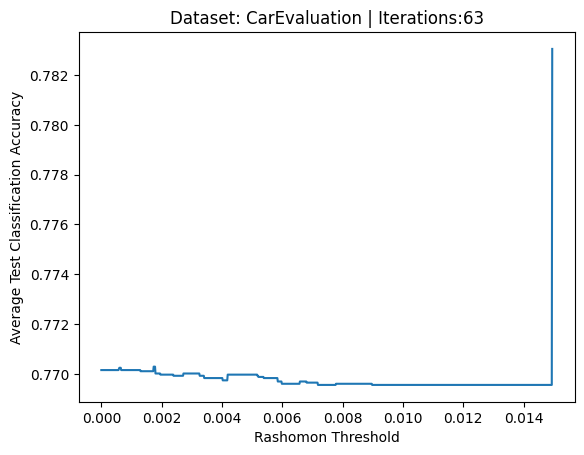

In [6]:
### Plot Accuracy ###
plt.plot(ThresholdValues_Mean, Epsilon_ClassAccuracy_Mean, label="Average Classification Accuracy")
plt.xlabel("Rashomon Threshold")
plt.ylabel("Average Test Classification Accuracy")
plt.title("Dataset: " + Dataset + " | Iterations:" +str(ThresholdValuesALL.shape[0]))
# plt.xticks(np.arange(0, 0.05, 0.005)) 
plt.show()

# F1 by Rashomon Threshold

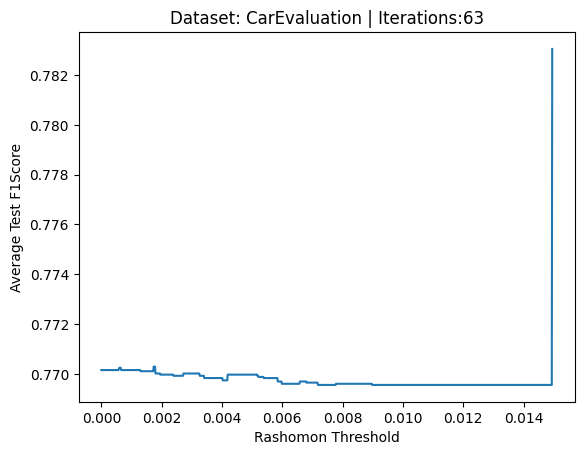

In [7]:
plt.plot(ThresholdValues_Mean, Epsilon_F1Score_Mean, label="Average F1 Score Accuracy")
plt.xlabel("Rashomon Threshold")
plt.ylabel("Average Test F1Score")
plt.title("Dataset: " + Dataset + " | Iterations:" +str(ThresholdValuesALL.shape[0]))
# plt.xticks(np.arange(0, 0.05, 0.005)) 
plt.show()